In [111]:
import pandas as pd
import os


In [112]:
LLM_score_thresh = 0.82
enrichr_adj_pval_thresh = 0.05
enrichr_JI_thresh = 0.1
coverage_thresh = 0.2

## TODO: LLM Coverage/JI
To be even handed, we need to process the LLM analyses to determine how many genes are used to support the chosen name.

Plan: present the 300 analyses to an LLM to extract the genes supporting the name and the genes discussed.

## Load the Enrichr query data

In [113]:

import os
import pandas as pd

# Read the TSV file into a Pandas DataFrame
LLM_genes_DF = pd.read_csv("data/omics_revamped_LLM_Enrichr_simVals_DF.tsv", delimiter="\t")
#LLM_genes_DF.shape
LLM_genes_DF.head(5)

,Unnamed: 0.1,Unnamed: 0,Source,GeneSetID,GeneSetName,GeneList,n_Genes,LLM Name,LLM Analysis,Score,Rank,Overlap,P-value,Adjusted P-value,Genes,Term,GO term,GO ID,GO_term_genes,LLM_name_GO_term_sim
0,0,0,NeST,Cluster1-10,Cluster1-10,CTRL HSD17B14 KIAA0232 PAQR8 PLA2G1B RNF145 SG...,12,Lipid Metabolism and Membrane Dynamics,"1. CTRL, or carboxyl-terminal esterase/lipase,...",0.85,0,2/21,0.000069,0.008264,PLA2G1B;HSD17B14,Lipid Catabolic Process (GO:0016042),Lipid Catabolic Process,GO:0016042,CES1 PNLIPRP1 PLA2G1B CES1P1 AOAH HSD17B14 APO...,0.603573
1,1,0,NeST,Cluster1-11,Cluster1-11,LMF1 MFHAS1 MR1 PLA2G1B RASL11A RNF145 SLC2A6 ...,12,Lipid Metabolism and Membrane Trafficking,1. LMF1 (Lipase Maturation Factor 1) is crucia...,0.85,0,2/85,0.001146,0.050873,PLA2G1B;MR1,Defense Response To Gram-positive Bacterium (G...,Defense Response To Gram-positive Bacterium,GO:0050830,GBP7 CHGA GBP6 GSDMD DEFB104A H2BC8 RNASE12 RN...,0.317063
2,2,0,NeST,Cluster1-12,Cluster1-12,AMY2B CNPY2 EGFL7 LDLR LPL LRP8 LRPAP1 MYLIP P...,12,Lipid Metabolism and Receptor-Mediated Endocyt...,"1. AMY2B (Amylase, alpha 2B) is an enzyme that...",0.88,0,4/189,0.000004,0.000671,VLDLR;SORL1;LRP8;LDLR,Endocytosis (GO:0006897),Endocytosis,GO:0006897,RALBP1 SCARA5 TBC1D2B AP1S1 TSC2 ARHGAP27 TICA...,0.607433
3,3,1,NeST,Cluster1-12,Cluster1-12,AMY2B CNPY2 EGFL7 LDLR LPL LRP8 LRPAP1 MYLIP P...,12,Lipid Metabolism and Receptor-Mediated Endocyt...,"1. AMY2B (Amylase, alpha 2B) is an enzyme that...",0.88,1,2/6,0.000005,0.000671,LRPAP1;LDLR,Negative Regulation Of Lipoprotein Particle Cl...,Negative Regulation Of Lipoprotein Particle Cl...,GO:0010985,KHSRP APOC3 APOC2 PCSK9 LDLR LRPAP1,0.440780
4,4,2,NeST,Cluster1-12,Cluster1-12,AMY2B CNPY2 EGFL7 LDLR LPL LRP8 LRPAP1 MYLIP P...,12,Lipid Metabolism and Receptor-Mediated Endocyt...,"1. AMY2B (Amylase, alpha 2B) is an enzyme that...",0.88,2,4/233,0.000008,0.000671,RELN;VLDLR;SORL1;LRP8,Positive Regulation Of Developmental Process (...,Positive Regulation Of Developmental Process,GO:0051094,ACVR1 KRT2 ISL1 SMARCA2 SMARCA4 CDC20 NEURL1 T...,0.150215


## Common functions

In [114]:
# functions to compute the Jaccard Index and coverage for the query gene list and the GO term genes
def get_JI(GeneList: str, enrichr_genes) -> float:
    # Check if enrichr_genes is a string
    if not isinstance(enrichr_genes, str):
        #print(f"Warning: enrichr_genes is not a string: {enrichr_genes}")
        return 0
    
    # Assume separation is the same
    geneSetGenes = GeneList.split(" ")
    enrichRGenes = enrichr_genes.split(" ")
    
    # Calculate the Jaccard Index (JI)
    intersection = set(geneSetGenes).intersection(set(enrichRGenes))
    union = set(geneSetGenes).union(set(enrichRGenes))
    
    JI = len(intersection) / len(union) if len(union) != 0 else 0
    
    return JI

def get_coverage(GeneList: str, enrichr_genes) -> float:
    # Check if enrichr_genes is a string
    if not isinstance(enrichr_genes, str):
        #print(f"Warning: enrichr_genes is not a string: {enrichr_genes}")
        return 0
    
    # Assume separation is the same
    geneSetGenes = GeneList.split(" ")
    enrichRGenes = enrichr_genes.split(" ")
    
    # Calculate the intersection
    intersection = set(geneSetGenes).intersection(set(enrichRGenes))
    
    # Calculate the coverage
    coverage = len(intersection) / len(geneSetGenes) if len(geneSetGenes) != 0 else 0
    
    return coverage

def create_success_contingency_table(df):
    # Make the LLM vs enrichr contingency table
    contingency_table = pd.crosstab(df['enrichr_success_TF'], df['LLM_success_TF'], rownames=['enrichr_success_TF'], colnames=['LLM_success_TF'])

    # Reorder the rows and columns
    contingency_table = contingency_table.reindex(index=[True, False], columns=[True, False])

    # Add the total column and row
    contingency_table['Total'] = contingency_table.sum(axis=1)
    contingency_table.loc['Total'] = contingency_table.sum(axis=0)

    return contingency_table

def select_rows_and_columns(df, number_of_rows=None):
    # Specify the ordered list of column names you want to return
    ordered_column_names = [
        'n_Genes', 'GeneList', 'LLM Name', 'Score', 'GO term', 'GO_term_genes',
        'Genes', 'Overlap', 'Adjusted P-value', 'coverage', 'enrichr_JI', 
        'LLM_success_TF', 'enrichr_success_TF'
    ]
    
    # If number_of_rows is not specified, select all rows
    if number_of_rows is None:
        result_df = df.loc[:, ordered_column_names]
    else:
        result_df = df.loc[:, ordered_column_names].head(number_of_rows)
    
    return result_df

## Add JI and coverage scores

In [115]:
# Apply the get_JI and get_coverage functions to each row and add new columns to the DataFrame
LLM_genes_DF['enrichr_JI'] = LLM_genes_DF.apply(lambda row: get_JI(row['GeneList'], 
                                                                   row['GO_term_genes']), 
                                                                   axis=1)

LLM_genes_DF['coverage'] = LLM_genes_DF.apply(lambda row: get_coverage(row['GeneList'], 
                                                                   row['GO_term_genes']), 
                                                                   axis=1)
LLM_genes_DF.shape

(11310, 22)

## Select Enrichr result with best APV that also meets JI threshold

In [116]:
# Alternative analysis in which the result is selected as the row with the lowest Adjusted P-value that passes both requirements
grouped = LLM_genes_DF.groupby(["Source", "GeneSetID", "GeneSetName", "GeneList"])

# Define a function to filter and select the appropriate row
def filter_and_select(df):
    # Filter rows that pass both Enrichr requirements
    filtered = df[(df['enrichr_JI'] >= enrichr_JI_thresh) & (df['Adjusted P-value'] <= enrichr_adj_pval_thresh)]
    
    if not filtered.empty:
        # If there are rows that pass both requirements, select the one with the lowest adjusted p-value
        return filtered.loc[filtered['Adjusted P-value'].idxmin()]
    else:
        # If no rows pass both requirements, select the one with the lowest adjusted p-value in the original group
        return df.loc[df['Adjusted P-value'].idxmin()]

# Apply the function to each group and reset the index
reduced_LLM_genes_by_apv_best_DF = grouped.apply(filter_and_select).reset_index(drop=True)

# Add the 'LLM_success_TF' and 'enrichr_success_TF' columns
reduced_LLM_genes_by_apv_best_DF['LLM_success_TF'] = reduced_LLM_genes_by_apv_best_DF['Score'] >= LLM_score_thresh
reduced_LLM_genes_by_apv_best_DF['enrichr_success_TF'] = ~((reduced_LLM_genes_by_apv_best_DF['Adjusted P-value'] > enrichr_adj_pval_thresh) | (reduced_LLM_genes_by_apv_best_DF['enrichr_JI'] < enrichr_JI_thresh))

print(create_success_contingency_table(reduced_LLM_genes_by_apv_best_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_by_apv_best_DF, 5)
result_df

LLM_success_TF      True  False  Total
enrichr_success_TF                    
True                  36      4     40
False                 97    163    260
Total                133    167    300


,n_Genes,GeneList,LLM Name,Score,GO term,GO_term_genes,Genes,Overlap,Adjusted P-value,coverage,enrichr_JI,LLM_success_TF,enrichr_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,Regulation Of Peroxisome Proliferator Activate...,ASXL2 ASXL1 PTGIS BMP2 CITED2 GPS2 LMO3 PLIN5 ...,CITED2;TWIST1,2/10,0.023830,0.083333,0.062500,True,False
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,Purine Ribonucleoside Monophosphate Catabolic ...,PNP NT5C1A NT5E HPRT1 SORD PRTFDC1 NT5C2,NT5E;HPRT1,2/7,0.059507,0.042553,0.038462,True,False
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,Response To Steroid Hormone,MED1 TGFB1 PAQR7 TGFB3 PAQR8 TGFB2 HSPA8 NR1H3...,CAV1;AKR1B1;THBS1,3/29,0.047162,0.050847,0.035294,False,False
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,Positive Regulation Of Protein Tyrosine Kinase...,PTPN1 IL34 ACE EGF FBXW7 SRCIN1 PRNP AGT EREG ...,GAS6;AREG,2/38,0.023945,0.222222,0.044444,False,False
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,SMAD Protein Signal Transduction,GDF11 TGFB1 TGFB3 JUN TGFB2 GDF15 BMP8B BMP8A ...,NUP93;GDF15;INHBB,3/51,0.002024,0.200000,0.047619,False,False


In [117]:
reduced_LLM_genes_by_apv_best_DF_novel = reduced_LLM_genes_by_apv_best_DF.loc[(reduced_LLM_genes_by_apv_best_DF['enrichr_success_TF'] == False)& (reduced_LLM_genes_by_apv_best_DF['LLM_success_TF'] == True), ['GeneSetID','n_Genes', 'GeneList', 'LLM Name', 'Score', 'GO term', 'GO_term_genes',
        'Genes', 'Overlap', 'Adjusted P-value', 'coverage', 'enrichr_JI', 
        'LLM_success_TF', 'enrichr_success_TF']]

## Select Enrichr result with best APV that also passes coverage threshold

In [118]:

# Define a function to filter and select the appropriate row
def filter_and_select_coverage(df):
    # Filter rows that pass both Enrichr requirements
    filtered = df[(df['coverage'] >= coverage_thresh) & (df['Adjusted P-value'] <= enrichr_adj_pval_thresh)]
    
    if not filtered.empty:
        # If there are rows that pass both requirements, select the one with the lowest adjusted p-value
        return filtered.loc[filtered['Adjusted P-value'].idxmin()]
    else:
        # If no rows pass both requirements, select the one with the lowest adjusted p-value in the original group
        return df.loc[df['Adjusted P-value'].idxmin()]

# Grouping the DataFrame by the specified columns
grouped = LLM_genes_DF.groupby(["Source", "GeneSetID", "GeneSetName", "GeneList"])

# Apply the function to each group and reset the index
reduced_LLM_genes_by_coverage_DF = grouped.apply(filter_and_select_coverage).reset_index(drop=True)

# Add the 'LLM_success_TF' and 'enrichr_success_TF' columns
reduced_LLM_genes_by_coverage_DF['LLM_success_TF'] = reduced_LLM_genes_by_coverage_DF['Score'] >= LLM_score_thresh
reduced_LLM_genes_by_coverage_DF['enrichr_success_TF'] = ~((reduced_LLM_genes_by_coverage_DF['Adjusted P-value'] > enrichr_adj_pval_thresh) | (reduced_LLM_genes_by_coverage_DF['coverage'] < coverage_thresh))

print(create_success_contingency_table(reduced_LLM_genes_by_coverage_DF))

result_df = select_rows_and_columns(reduced_LLM_genes_by_coverage_DF, 5)
result_df

LLM_success_TF      True  False  Total
enrichr_success_TF                    
True                  72     17     89
False                 61    150    211
Total                133    167    300


,n_Genes,GeneList,LLM Name,Score,GO term,GO_term_genes,Genes,Overlap,Adjusted P-value,coverage,enrichr_JI,LLM_success_TF,enrichr_success_TF
0,24,CITED2 COL5A1 CRABP2 KCTD12 MDFIC MMP2 NRP1 OR...,Cellular Matrix Remodeling and Tissue Development,0.85,Regulation Of Peroxisome Proliferator Activate...,ASXL2 ASXL1 PTGIS BMP2 CITED2 GPS2 LMO3 PLIN5 ...,CITED2;TWIST1,2/10,0.023830,0.083333,0.062500,True,False
1,47,1060P11.3 ADM AHR AMIGO2 ARL4C ATP10D CAV2 CD4...,Cellular Adhesion and Extracellular Matrix Int...,0.85,Purine Ribonucleoside Monophosphate Catabolic ...,PNP NT5C1A NT5E HPRT1 SORD PRTFDC1 NT5C2,NT5E;HPRT1,2/7,0.059507,0.042553,0.038462,True,False
2,59,ABAT ASS1 CHI3L1 CHST2 CLDN3 EIF5B FRZB GAL HE...,System of unrelated proteins,0.00,Response To Steroid Hormone,MED1 TGFB1 PAQR7 TGFB3 PAQR8 TGFB2 HSPA8 NR1H3...,CAV1;AKR1B1;THBS1,3/29,0.047162,0.050847,0.035294,False,False
3,9,AMIGO2 AREG GAS6 GPR37 IFT57 PELI1 SQLE AKAP12...,System of unrelated proteins,0.00,Positive Regulation Of Protein Tyrosine Kinase...,PTPN1 IL34 ACE EGF FBXW7 SRCIN1 PRNP AGT EREG ...,GAS6;AREG,2/38,0.023945,0.222222,0.044444,False,True
4,15,1060P11.3 CPE EFNB2 HIST1H2AC IL1R2 INHBB LYPD...,System of unrelated proteins,0.00,SMAD Protein Signal Transduction,GDF11 TGFB1 TGFB3 JUN TGFB2 GDF15 BMP8B BMP8A ...,NUP93;GDF15;INHBB,3/51,0.002024,0.200000,0.047619,False,True


In [119]:
# Write the DataFrames to TSV files
reduced_LLM_genes_by_apv_best_DF.to_csv("data/omics_revamped_LLM_Enrichr_simVals_failure_by_apv_best_JI.tsv", sep="\t", index=False)
reduced_LLM_genes_by_coverage_DF.to_csv("data/omics_revamped_LLM_Enrichr_simVals_failure_by_coverage.tsv", sep="\t", index=False)

## Plot the JI, overlap threshold 

In [120]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

def coverage_thresholding(df, col, coverage_thresh_list = np.arange(0.0, 1.1, 0.1), enrichr_adj_pval_thresh = 0.05):

    # Initialize the result DataFrame with 0
    coverage_thresh_eval_DF = pd.DataFrame({
        'coverage_thresh': coverage_thresh_list,
        'num_success': np.zeros(len(coverage_thresh_list)), 
        'perc_success': np.zeros(len(coverage_thresh_list)),
        'perc_meetsThresh': np.zeros(len(coverage_thresh_list)),
        'perc_success_normed': 100
    })

    # Loop through each coverage threshold
    for i, coverage_thresh in enumerate(coverage_thresh_list):
        # Calculate perc_success: percentage of rows that meet both the coverage and adjusted p-value thresholds
        coverage_threshCol = ((df['Adjusted P-value'] <= enrichr_adj_pval_thresh) & (df[col] >= coverage_thresh)) 
        coverage_thresh_eval_DF.loc[i, 'num_success'] = sum(coverage_threshCol)
        coverage_thresh_eval_DF.loc[i, 'perc_success'] = (sum(coverage_threshCol) / len(df)) * 100
        # Calculate perc_success_normed: percentage of rows that meet both the coverage and adjusted p-value thresholds, normalized by the number of rows that meet the adjusted p-value threshold
        pval_threshCol = (df['Adjusted P-value'] <= enrichr_adj_pval_thresh)
        # print(sum(pval_threshCol))
        # print(sum(coverage_threshCol))
        coverage_thresh_eval_DF.loc[i, 'perc_success_normed'] = (sum(coverage_threshCol) / sum(pval_threshCol)) * 100
        
        # Calculate perc_meetsThresh: percentage of rows that meet the coverage threshold
        coverage_threshOnlyCol = (df[col] >= coverage_thresh)
        coverage_thresh_eval_DF.loc[i, 'perc_meetsThresh'] = (sum(coverage_threshOnlyCol) / len(df)) * 100
        
        # # Calculate accuracy
        # coverage_threshCol = coverage_threshCol.astype(int) # Convert boolean to integer
        # LLM_success_TF = df['LLM_success_TF'].astype(int)
        # if len(np.unique(coverage_threshCol)) > 1:
        #     c = confusion_matrix(coverage_threshCol, LLM_success_TF)
        #     coverage_thresh_eval_DF.loc[i, 'accuracy'] = (c[0, 0] + c[1, 1]) / c.sum()
        # else:
        #     coverage_thresh_eval_DF.loc[i, 'accuracy'] = np.nan  # Handle the case where the confusion matrix is not defined
    return coverage_thresh_eval_DF

coverage_thresh_eval_DF = coverage_thresholding(reduced_LLM_genes_by_coverage_DF, 'coverage')

# Display the result DataFrame
print(coverage_thresh_eval_DF)

    

    coverage_thresh  num_success  perc_success  perc_meetsThresh  \
0               0.0        220.0     73.333333        100.000000   
1               0.1        147.0     49.000000         54.666667   
2               0.2         89.0     29.666667         30.333333   
3               0.3         51.0     17.000000         17.000000   
4               0.4         30.0     10.000000         10.000000   
5               0.5         24.0      8.000000          8.000000   
6               0.6         18.0      6.000000          6.000000   
7               0.7         11.0      3.666667          3.666667   
8               0.8          7.0      2.333333          2.333333   
9               0.9          1.0      0.333333          0.333333   
10              1.0          1.0      0.333333          0.333333   

    perc_success_normed  
0            100.000000  
1             66.818182  
2             40.454545  
3             23.181818  
4             13.636364  
5             10.909091  
6

In [63]:
JI_thresh_eval_DF = coverage_thresholding(reduced_LLM_genes_by_apv_best_DF, 'enrichr_JI', coverage_thresh_list = np.arange(0.0, 1.05, 0.05))

# Display the result DataFrame
print(JI_thresh_eval_DF)

    coverage_thresh  num_success  perc_success  perc_meetsThresh  \
0              0.00        220.0     73.333333        100.000000   
1              0.05        106.0     35.333333         36.000000   
2              0.10         40.0     13.333333         13.333333   
3              0.15         10.0      3.333333          3.333333   
4              0.20          3.0      1.000000          1.000000   
5              0.25          2.0      0.666667          0.666667   
6              0.30          0.0      0.000000          0.000000   
7              0.35          0.0      0.000000          0.000000   
8              0.40          0.0      0.000000          0.000000   
9              0.45          0.0      0.000000          0.000000   
10             0.50          0.0      0.000000          0.000000   
11             0.55          0.0      0.000000          0.000000   
12             0.60          0.0      0.000000          0.000000   
13             0.65          0.0      0.000000  

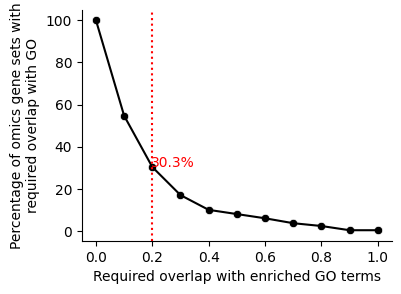

In [60]:
# Plotting the results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4,3))
sns.scatterplot(data=coverage_thresh_eval_DF, x='coverage_thresh', y='perc_meetsThresh', color='black')
sns.lineplot(data=coverage_thresh_eval_DF, x='coverage_thresh', y='perc_meetsThresh', color='black')

# Adding vertical lines at specific thresholds
plt.axvline(x=0.2, color='red', linestyle='dotted')
# label the line as the percentage of omics gene sets that meet the threshold
perc_meetsThresh = coverage_thresh_eval_DF.loc[coverage_thresh_eval_DF['coverage_thresh'] == 0.2, 'perc_meetsThresh'].values[0]
plt.text(0.2+0.15, perc_meetsThresh, f'{perc_meetsThresh:.1f}%', color='red', ha='right')
# Adding labels and title
plt.xlabel('Required overlap with enriched GO terms')
plt.ylabel('Percentage of omics gene sets with\nrequired overlap with GO')
sns.despine()

# Display the plot
plt.show()

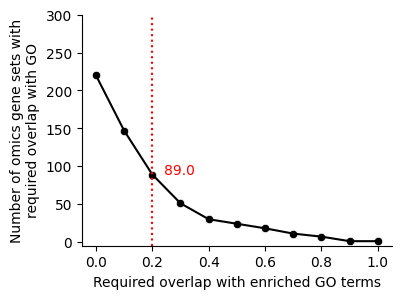

In [61]:
# Plotting the results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4,3))
sns.scatterplot(data=coverage_thresh_eval_DF, x='coverage_thresh', y='num_success', color='black')
sns.lineplot(data=coverage_thresh_eval_DF, x='coverage_thresh', y='num_success', color='black')
plt.ylim(-5, 300)
# Adding vertical lines at specific thresholds
plt.axvline(x=0.2, color='red', linestyle='dotted')
# label the line as the percentage of omics gene sets that meet the threshold
perc_meetsThresh = coverage_thresh_eval_DF.loc[coverage_thresh_eval_DF['coverage_thresh'] == 0.2, 'num_success'].values[0]
plt.text(0.2+0.15, perc_meetsThresh, f'{perc_meetsThresh}', color='red', ha='right')
# Adding labels and title
plt.xlabel('Required overlap with enriched GO terms')
plt.ylabel('Number of omics gene sets with\nrequired overlap with GO')
sns.despine()

# Display the plot
plt.show()

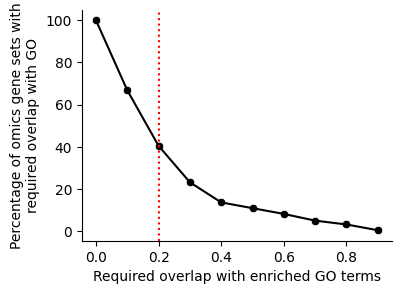

In [19]:
# Plotting the results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4,3))
sns.scatterplot(data=coverage_thresh_eval_DF, x='coverage_thresh', y='perc_success_normed', color='black')
sns.lineplot(data=coverage_thresh_eval_DF, x='coverage_thresh', y='perc_success_normed', color='black')

# Adding vertical lines at specific thresholds
plt.axvline(x=0.2, color='red', linestyle='dotted')

# Adding labels and title
plt.xlabel('Required overlap with enriched GO terms')
plt.ylabel('Percentage of omics gene sets with\nrequired overlap with GO')
sns.despine()

# Display the plot
plt.show()

# plot for the alt#3

using JI thresholding

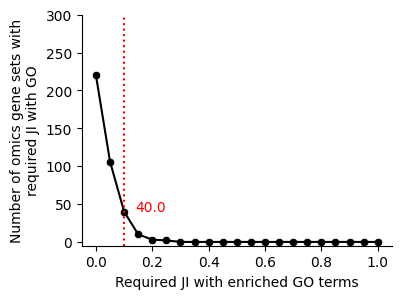

In [67]:
# Plotting the results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4,3))
sns.scatterplot(data=JI_thresh_eval_DF, x='coverage_thresh', y='num_success', color='black')
sns.lineplot(data=JI_thresh_eval_DF, x='coverage_thresh', y='num_success', color='black')
plt.ylim(-5, 300)
# Adding vertical lines at specific thresholds
plt.axvline(x=0.1, color='red', linestyle='dotted')
# label the line as the percentage of omics gene sets that meet the threshold
perc_meetsThresh = JI_thresh_eval_DF.loc[JI_thresh_eval_DF['coverage_thresh'] == 0.1, 'num_success'].values[0]
plt.text(0.1+0.15, perc_meetsThresh, f'{perc_meetsThresh}', color='red', ha='right')
# Adding labels and title
plt.xlabel('Required JI with enriched GO terms')
plt.ylabel('Number of omics gene sets with\nrequired JI with GO')
sns.despine()

# Display the plot
plt.show()

In [36]:

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

df = reduced_LLM_genes_by_apv_best_DF.copy()
col = 'LLM_name_GO_term_sim'

sim_thresh_list = np.arange(0.0, 1.05, 0.05) # the semantic similarity between GO name and LLM name thresholding 

# Initialize the result DataFrame with 0
sim_thresh_eval_DF = pd.DataFrame({
    'semantic_sim_thresh': sim_thresh_list,
    'num_success': np.zeros(len(sim_thresh_list)),
    'perc_success': np.zeros(len(sim_thresh_list)),
    'perc_meetsThresh': np.zeros(len(sim_thresh_list)),
    'perc_success_normed': 100
})

# Loop through each coverage threshold
for i, sim_thresh in enumerate(sim_thresh_list):
    # Calculate perc_success: percentage of rows that meet both the confidence and semantic sim thresholds
    confidence_sim_threshCol = ((df['Score'] >= LLM_score_thresh) & (df[col] <= sim_thresh)) 
    sim_thresh_eval_DF.loc[i, 'num_success'] = sum(confidence_sim_threshCol)
    sim_thresh_eval_DF.loc[i, 'perc_success'] = (sum(confidence_sim_threshCol) / len(df)) * 100
    # Calculate perc_success_normed: percentage of rows that meet both the confidence and semantic sim thresholds, normalized by the number of rows that meet the confidence threshold
    confidence_threshCol = (df['Score'] >= LLM_score_thresh)
    sim_thresh_eval_DF.loc[i, 'perc_success_normed'] = (sum(confidence_sim_threshCol) / sum(confidence_threshCol)) * 100

    
    # Calculate perc_meetsThresh: percentage of rows that meet the semantic sim threshold
    sim_threshOnlyCol = (df[col] <= sim_thresh)
    sim_thresh_eval_DF.loc[i, 'perc_meetsThresh'] = (sum(sim_threshOnlyCol) / len(df)) * 100

# Display the result DataFrame
print(sim_thresh_eval_DF)

    semantic_sim_thresh  num_success  perc_success  perc_meetsThresh  \
0                  0.00          0.0      0.000000          0.000000   
1                  0.05          0.0      0.000000          0.000000   
2                  0.10          0.0      0.000000          0.000000   
3                  0.15          1.0      0.333333          1.333333   
4                  0.20          6.0      2.000000          9.333333   
5                  0.25         16.0      5.333333         22.333333   
6                  0.30         27.0      9.000000         36.333333   
7                  0.35         38.0     12.666667         54.333333   
8                  0.40         55.0     18.333333         67.666667   
9                  0.45         71.0     23.666667         77.333333   
10                 0.50         85.0     28.333333         83.666667   
11                 0.55         98.0     32.666667         88.333333   
12                 0.60        112.0     37.333333         93.00

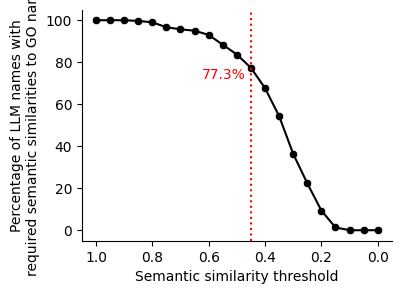

In [69]:
# Plotting the results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4,3))
sns.scatterplot(data=sim_thresh_eval_DF, x='semantic_sim_thresh', y='perc_meetsThresh', color='black')
sns.lineplot(data=sim_thresh_eval_DF, x='semantic_sim_thresh', y='perc_meetsThresh', color='black')
# reverse the x-axis
plt.gca().invert_xaxis()

# Adding vertical lines at specific thresholds
threshold = 0.45
plt.axvline(x=threshold, color='red', linestyle='dotted')
# label the line as the percentage of omics gene sets that meet the threshold
perc_meetsThresh = sim_thresh_eval_DF.loc[sim_thresh_eval_DF['semantic_sim_thresh'] == threshold, 'perc_meetsThresh'].values[0]
plt.text(threshold +0.02, perc_meetsThresh-5, f'{perc_meetsThresh:.1f}%', color='red', ha='right')
# Adding labels 
plt.xlabel('Semantic similarity threshold')
plt.ylabel('Percentage of LLM names with\nrequired semantic similarities to GO names')
sns.despine()

# Display the plot
plt.show()

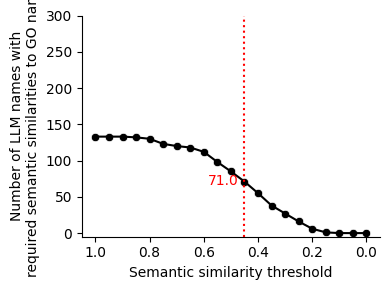

In [68]:
# Plotting the results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4,3))
sns.scatterplot(data=sim_thresh_eval_DF, x='semantic_sim_thresh', y='num_success', color='black')
sns.lineplot(data=sim_thresh_eval_DF, x='semantic_sim_thresh', y='num_success', color='black')
# reverse the x-axis
plt.gca().invert_xaxis()
plt.ylim(-5, 300)
# Adding vertical lines at specific thresholds
threshold = 0.45
plt.axvline(x=threshold, color='red', linestyle='dotted')
# # label the line as the percentage of omics gene sets that meet the threshold
perc_meetsThresh = sim_thresh_eval_DF.loc[sim_thresh_eval_DF['semantic_sim_thresh'] == threshold, 'num_success'].values[0]
plt.text(threshold +0.02, perc_meetsThresh-5, f'{perc_meetsThresh}', color='red', ha='right')
# Adding axis labels 
plt.xlabel('Semantic similarity threshold')
plt.ylabel('Number of LLM names with\nrequired semantic similarities to GO names')
plt.tight_layout()
sns.despine()

# Display the plot
plt.show()

In [122]:
## after getting the supporting genes from LLM analysis 

import pandas as pd 
result_df = pd.read_csv("data/omics_revamped_LLM_Enrichr_simVals__genecounts_DF.tsv", sep="\t")
# reduced_LLM_genes_by_apv_best_DF = pd.read_csv("data/omics_revamped_LLM_Enrichr_simVals_failure_by_apv_best_JI.tsv", sep="\t")
reduced_LLM_genes_by_coverage_DF = pd.read_csv("data/omics_revamped_LLM_Enrichr_simVals_failure_by_coverage.tsv", sep="\t")

merged_df = pd.merge(reduced_LLM_genes_by_coverage_DF, result_df, on=['Source','GeneSetID','GeneSetName', 'GeneList', 'n_Genes'], how='left')
print(merged_df.shape)

(300, 29)


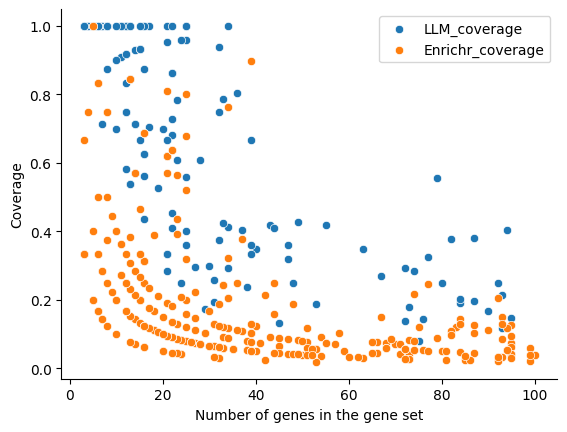

In [127]:
# check correlation between the number of genes and the coverage
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=merged_df, x='n_Genes', y='LLM_coverage', label = 'LLM_coverage')
sns.scatterplot(data=merged_df, x='n_Genes', y='coverage', label= 'Enrichr_coverage')
plt.xlabel('Number of genes in the gene set')
plt.ylabel('Coverage')
plt.legend()
sns.despine()

In [88]:
merged_df.sort_values(by='LLM_coverage', ascending=True, inplace=True)
merged_df.to_csv("data/omics_revamped_LLM_Enrichr_simVals__genecounts_DF_sorted.tsv", sep="\t", index=False)

In [124]:

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

df = merged_df.copy()
col = 'LLM_coverage'

coverage_thresh_list = np.arange(0.0, 1.1, 0.1) # the semantic similarity between GO name and LLM name thresholding 

# Initialize the result DataFrame with 0
coverage_thresh_eval_DF = pd.DataFrame({
    'coverage_thresh': coverage_thresh_list,
    'num_success': np.zeros(len(coverage_thresh_list)), 
    'perc_success': np.zeros(len(coverage_thresh_list)),
    'perc_meetsThresh': np.zeros(len(coverage_thresh_list)),
    'perc_success_normed': 100
})

# Loop through each coverage threshold
for i, coverage_thresh in enumerate(coverage_thresh_list):
    # Calculate perc_success: percentage of rows that meet both the coverage and confidencee thresholds
    coverage_threshCol = ((df['Score'] >= 0.82) & (df[col] >= coverage_thresh)) 
    coverage_thresh_eval_DF.loc[i, 'num_success'] = sum(coverage_threshCol)
    coverage_thresh_eval_DF.loc[i, 'perc_success'] = (sum(coverage_threshCol) / len(df)) * 100
    # Calculate perc_success_normed: percentage of rows that meet both the coverage and confidence thresholds, normalized by the number of rows that meet the confidence threshold
    confidence_threshCol = (df['Score'] >= 0.82)

    # print(sum(coverage_threshCol))
    coverage_thresh_eval_DF.loc[i, 'perc_success_normed'] = (sum(coverage_threshCol) / sum(confidence_threshCol)) * 100
    
    # Calculate perc_meetsThresh: percentage of rows that meet the coverage threshold
    coverage_threshOnlyCol = (df[col] >= coverage_thresh)
    coverage_thresh_eval_DF.loc[i, 'perc_meetsThresh'] = (sum(coverage_threshOnlyCol) / len(df)) * 100
        

# Display the result DataFrame
print(coverage_thresh_eval_DF)

    coverage_thresh  num_success  perc_success  perc_meetsThresh  \
0               0.0        133.0     44.333333         45.000000   
1               0.1        132.0     44.000000         44.666667   
2               0.2        120.0     40.000000         40.666667   
3               0.3        105.0     35.000000         35.666667   
4               0.4         92.0     30.666667         31.333333   
5               0.5         80.0     26.666667         27.333333   
6               0.6         72.0     24.000000         24.666667   
7               0.7         60.0     20.000000         20.666667   
8               0.8         50.0     16.666667         17.333333   
9               0.9         43.0     14.333333         15.000000   
10              1.0         32.0     10.666667         11.333333   

    perc_success_normed  
0            100.000000  
1             99.248120  
2             90.225564  
3             78.947368  
4             69.172932  
5             60.150376  
6

In [125]:
coverageJI_thresh_eval_DF = coverage_thresholding(merged_df, 'coverage', coverage_thresh_list = np.arange(0.0, 1.1, 0.1))

# Display the result DataFrame
print(coverageJI_thresh_eval_DF)

    coverage_thresh  num_success  perc_success  perc_meetsThresh  \
0               0.0        220.0     73.333333        100.000000   
1               0.1        147.0     49.000000         54.666667   
2               0.2         89.0     29.666667         30.333333   
3               0.3         51.0     17.000000         17.000000   
4               0.4         30.0     10.000000         10.000000   
5               0.5         24.0      8.000000          8.000000   
6               0.6         18.0      6.000000          6.000000   
7               0.7         11.0      3.666667          3.666667   
8               0.8          7.0      2.333333          2.333333   
9               0.9          1.0      0.333333          0.333333   
10              1.0          1.0      0.333333          0.333333   

    perc_success_normed  
0            100.000000  
1             66.818182  
2             40.454545  
3             23.181818  
4             13.636364  
5             10.909091  
6

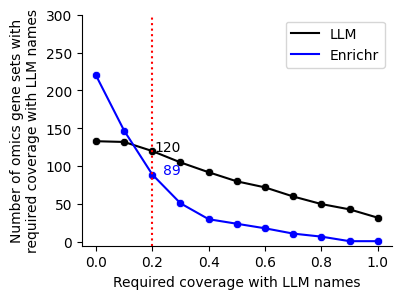

In [126]:
# Plotting the results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4,3))
sns.scatterplot(data=coverage_thresh_eval_DF, x='coverage_thresh', y='num_success', color='black')
sns.lineplot(data=coverage_thresh_eval_DF, x='coverage_thresh', y='num_success', color='black', label='LLM')
# plot for JI 
sns.scatterplot(data=coverageJI_thresh_eval_DF, x='coverage_thresh', y='num_success', color='blue')
sns.lineplot(data=coverageJI_thresh_eval_DF, x='coverage_thresh', y='num_success', color='blue', label='Enrichr')

plt.ylim(-5, 300)
# Adding vertical lines at specific thresholds
plt.axvline(x=0.2, color='red', linestyle='dotted')
# label the line as the percentage of omics gene sets that meet the threshold
perc_meetsThresh = coverage_thresh_eval_DF.loc[coverage_thresh_eval_DF['coverage_thresh'] == 0.2, 'num_success'].values[0]
plt.text(0.2+0.1, perc_meetsThresh, f'{int(perc_meetsThresh)}', color='black', ha='right')

perc_meetsThresh_enrichr = coverageJI_thresh_eval_DF.loc[coverageJI_thresh_eval_DF['coverage_thresh'] == 0.2, 'num_success'].values[0]
plt.text(0.2+0.1, perc_meetsThresh_enrichr, f'{int(perc_meetsThresh_enrichr)}', color='blue', ha='right')
# Adding labels and title
plt.xlabel('Required coverage with LLM names')
plt.ylabel('Number of omics gene sets with\nrequired coverage with LLM names')
plt.legend()
sns.despine()

# Display the plot
plt.show()